In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from nbdev import *

In [ ]:
# TODO create inference dataframe for testing inference code

In [ ]:
#default_exp inference

## Imports

In [ ]:
#export
import ijson
import pkg_resources
import pandas as pd
from cytoolz import itertoolz
from tqdm.notebook import tqdm

In [ ]:
from nnanno.core import *
from nnanno.sample import *

In [ ]:
#export
from typing import (
    Any,
    Optional,
    Union,
    Dict,
    List,
    Tuple,
    Set,
    Iterable,
)
from PIL import Image
import PIL

In [ ]:
#export 
from fastai.vision.all import *

## Learner

In [ ]:
dls = ImageDataLoaders.from_csv('../ph/ads/', 'ads_upsampled.csv',folder='images', fn_col='file', label_col='label',item_tfms=Resize(64,ResizeMethod.Squish))

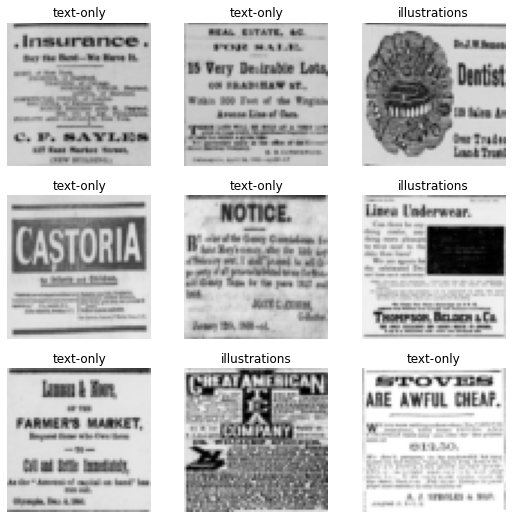

In [ ]:
dls.show_batch()

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=F1Score())
learn.fit(1)

# nnPredict

## helpers

### Missing images
Because we are dealing with images requested via the web we have to deal with the occasional hiccup. This hiccup could include requested image not being returned from an IIIF request, or a network issue etc. The method we use to load images is defined in `core`

In [ ]:
?load_url_image

Signature: load_url_image(url: str, mode='RGB') -> Union[PIL.Image.Image, NoneType]
Docstring: Attempts to load an image from `url` returns `None` if request times out or no image at url
File:      ~/Documents/LWM/tutorials/nnanno/nnanno/core.py
Type:      function


`load_url_image` will sometimes return `None`. When we're running inference this can cause an issue because we want to create batches of images to speed up inference. We don't want to include `None`s in a batch of images to predict. To get around this we create a function which filters a batch of images and replaces `None` with a fake image. This function also returns the index of items which were originally `None`. This allows us to use this index of items which were None to replace any predictions made for dummy images with `np.nan`

In [ ]:
# export
def _filter_replace_none_image(results:List[Optional[PIL.Image.Image]]):
    fakeim = Image.fromarray(244 * np.ones((250,250,3), np.uint8))
    results = L(results)
    none_image_index = results.argwhere(lambda x: x is None) # Gets the index for images which are none
    results[none_image_index] = fakeim # Replaces None with fakeim
    return results.items, none_image_index

In [ ]:
# hide
# TODO replace get_image_files with test images
im_files = (get_image_files('../ph/ads/images'))[:8] 
results = list(map(PILImage.create,im_files))
results.append(None)
results = [None] + results
image_batch,none_image_index =_filter_replace_none_image(results)
assert len(results) == len(image_batch)
assert none_image_index.items == [0,9] # check indexes are at the start and end of list

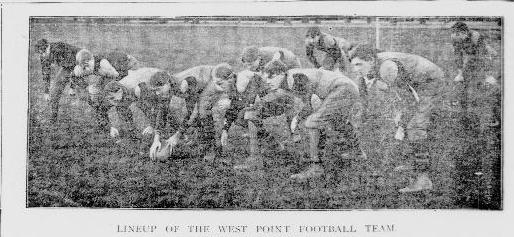

In [ ]:
url = 'https://news-navigator.labs.loc.gov/data/dlc_fiji_ver01/data/sn83030214/00175040936/1900102801/0519/001_0_99.jpg'
im = load_url_image(url);im

In [ ]:
im_files = (get_image_files('../ph/ads/images'))[:4]
images = list(map(PILImage.create, im_files))
results = [None] + images 
images,index =_filter_replace_none_image(results)

image_batch = [np.array(im) for im in images]
test_data = learn.dls.test_dl(image_batch)
pred_tuple = learn.get_preds(dl=test_data, with_decoded=True)
pred_decoded = L(pred_tuple[2], use_list=True)
pred_tensor =  L(pred_tuple[0],use_list=True)
pred_decoded[index] = np.nan; pred_tensor[index] = np.nan
pred_decoded.items, pred_tensor.items

([nan, tensor(1), tensor(1), tensor(1), tensor(0)],
 [nan,
  tensor([0.0069, 0.9931]),
  tensor([0.3586, 0.6414]),
  tensor([0.2871, 0.7129]),
  tensor([0.6150, 0.3850])])

In [ ]:
url = 'https://news-navigator.labs.loc.gov/data/dlc_fiji_ver01/data/sn83030214/00175040936/1900102801/0519/001_0_99.jpg'
im = load_url_image(url)
images = [im,im,im]
results = [None] + images 
images,index =_filter_replace_none_image(results)
image_batch = [np.array(im) for im in images]
list(map(np.shape,image_batch))

[(250, 250, 3), (237, 514, 3), (237, 514, 3), (237, 514, 3)]

In [ ]:
#export
def _create_pred_header(fname, dls=None):
    columns=[
            "filepath",
            "pub_date",
            "page_seq_num",
            "edition_seq_num",
            "batch",
            "lccn",
            "box",
            "score",
            "ocr",
            "place_of_publication",
            "geographic_coverage",
            "name",
            "publisher",
            "url",
            "page_url",
            "iiif_url",
            "pred_decoded"]
    if dls:
        columns = columns + (list(dls.vocab))
    return pd.DataFrame(columns=columns).to_csv(fname, index=None)

In [ ]:
#hide
_create_pred_header('test_header.csv')
df = pd.read_csv('test_header.csv')
assert df.columns.to_list() == ['filepath', 'pub_date', 'page_seq_num', 'edition_seq_num', 'batch',
       'lccn', 'box', 'score', 'ocr', 'place_of_publication',
       'geographic_coverage', 'name', 'publisher', 'url', 'page_url',
       'iiif_url', 'pred_decoded']
Path('test_header.csv').unlink()
_create_pred_header('test_header.csv', dls=dls)
df = pd.read_csv('test_header.csv')
assert len(df[dls.vocab].columns) == dls.c
Path('test_header.csv').unlink()

In [ ]:
def _create_year_csv(out_dir, year,kind,dls=None):
    fname = Path(f"{out_dir}/{year}_{kind}.csv")
    _create_pred_header(fname, dls)
    return fname

In [ ]:
def _create_year_json(out_dir, year,kind, batch):
    fname = Path(f"{out_dir}/{year}_{kind}_{batch}.json")
    return fname

In [ ]:
#hide
Path('test_csv').mkdir()
_create_year_csv('test_csv',1850,'ads')
assert Path('test_csv/1850_ads.csv').exists() == True
Path('test_csv/1850_ads.csv').unlink() ;Path('test_csv/').rmdir()

## Predict

In [ ]:
# TODO how to save to json 

# TODO save to csv a bit more nicely 

In [ ]:
# export
class nnPredict:
    def __init__(self, learner, tyr_gpu=True):
        self.learner = learner
        self.learner.model
        self.population = pd.read_csv(pkg_resources.resource_stream('nnanno', 'data/all_year_counts.csv'), 
                                      index_col=0)
    def _get_year_sample_size(self, kind,year):
        return self.population[f"{kind}_count"][year]
    
    def predict_from_sample_df(self, sample_df,bs=16):
        # TODO docstring
        self.sample_df = sample_df
       # Path(out_dir).mkdir(exist_ok=True)
        self.sample_df['iiif_url'] = self.sample_df.apply(lambda x: iiif_df_apply(x,size=(250,250)),axis=1)
        dfs = []
        splits = round(len(self.sample_df)/bs)
        for df in tqdm(np.array_split(sample_df, splits)):
            futures=[]
            for url in df['iiif_url'].to_list():
                with ThreadPoolExecutor() as e:
                    future = e.submit(load_url_image,url)
                    futures.append(future)
            results = [future.result() for future in futures]
            image_list, none_index = _filter_replace_none_image(results)
            im_as_arrays = [np.array(image) for image in image_list]
            if len(none_index) >0:
                        tqdm.write(f"{none_index} skipped")
            else:
                pass
            test_data = self.learner.dls.test_dl(im_as_arrays)
            with self.learner.no_bar():
                pred_tuple = self.learner.get_preds(dl=test_data, with_decoded=True)
            pred_decoded = L(pred_tuple[2], use_list=True)
            pred_tensor =  L(pred_tuple[0],use_list=None)
            pred_decoded[none_index] = np.nan; pred_tensor[none_index] = np.nan
            df["pred_decoded"] = pred_decoded.items
            df["pred_decoded"] = df['pred_decoded'].astype(float)
            # create an empty df column for each class in dls.vocab
            for c in dls.vocab:
                df[f'{c}_prob'] = ''
            # append the tensor predictions to the last `c` colomns of the df
            df.iloc[:,-dls.c:] = np.hsplit(pred_tensor.numpy(),dls.c) #split into columns
            #df.to_csv('test.csv', header=None, index=None, mode="a")
            dfs.append(df)
        return dfs



    def predict(
        self,
        kind: str,
        out_dir: str,
        bs: int = 32,
        sample_size: Union[int, float] = None,
        start_year: int = 1850,
        end_year: int = 1950,
        step: int = 1,
        year_sample:bool=True,
    ):
#         if Path(out_dir).exists() and len(os.scandir(out_dir)) >=1:
#             raise ValueError(f'{out_fn} already exists and is not empty')
        Path(out_dir).mkdir(exist_ok=True)
#         if sample_size and not year_sample:
#             if not type(sample_size) == int:
#                 raise ValueError(
#                     f"type{sample_size} is not an int. Fractions are only supported for sampling by year"
#                 )
#             sample_size = calc_year_from_total(sample_size, start_year, end_year, step)

        years = range(start_year, end_year + 1, step)
        total = self._get_year_sample_size(kind,years).sum()
        pbar = tqdm(years,total=total)
        for year in pbar:
            out_fn = _create_year_csv(out_dir,year,kind, dls)
            pbar.set_description(f"Predicting: {year}, total progress")
            if kind == ('ads' and int(year) >=1870) or (kind == 'headlines'):
                s = create_session()
            else:
                s = create_cached_session() 
            with s.get(get_json_url(year, kind), timeout=60) as r: 
                if r.from_cache:
                    tqdm.write('using cache')
                data = ijson.items(r.content, "item")
                # TODO add sample approach
                batches = itertoolz.partition_all(bs, iter(data))
                year_total = self._get_year_sample_size(kind,year)
                for i,batch in enumerate(tqdm(
                    batches, total=round(year_total//bs),leave=False, desc='Batch Progress')):
                    df = pd.DataFrame(batch)
                    df["iiif_url"] = df.apply(lambda x: iif_df_apply(x), axis=1)
                    futures = []
                    workers = get_max_workers(df)
                    for iif_url in df["iiif_url"].values:
                        with concurrent.futures.ThreadPoolExecutor(workers) as e:
                            future = e.submit(load_url_image, iif_url)
                            futures.append(future)
                    results = [future.result() for future in futures]
                    image_list, none_index = _filter_replace_none_image(results)
                    im_as_arrays = [np.array(image) for image in image_list]
                    if len(none_index) >0:
                        tqdm.write(f"{none_index} skipped")
                    else:
                        pass
                    test_data = learn.dls.test_dl(im_as_arrays)
                    with self.learner.no_bar():
                        pred_tuple = self.learner.get_preds(dl=test_data, with_decoded=True)
                    pred_decoded = L(pred_tuple[2], use_list=True)
                    pred_tensor =  L(pred_tuple[0],use_list=None)
                    pred_decoded[none_index] = np.nan; pred_tensor[none_index] = np.nan
                    df["pred_decoded"] = pred_decoded.items
                    df["pred_decoded"] = df['pred_decoded'].astype(float)
                    # create an empty df column for each class in dls.vocab
                    for c in dls.vocab:
                        df[f'{c}_prob'] = ''
                    # append the tensor predictions to the last `c` colomns of the df
                    df.iloc[:,-dls.c:] = np.hsplit(pred_tensor.numpy(),dls.c) #split into columns
                    df.to_csv(out_fn, header=None, index=None, mode="a")
                    pbar.update(bs)

In [ ]:
predictor = nnPredict(learn)

In [ ]:
sampler = nnSampler()
sample_df = sampler.create_sample(10, 'ads', end_year=1850,step=1)
dfs = predictor.predict_from_sample_df(sample_df)

100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


In [ ]:
df = pd.concat(dfs)
df

,filepath,pub_date,page_seq_num,edition_seq_num,batch,lccn,box,score,ocr,place_of_publication,geographic_coverage,name,publisher,url,page_url,iiif_url,pred_decoded,illustrations_prob,text-only_prob
0,mimtptc_beulah_ver01/data/sn89080032/00415668132/1850082701/0833/001_6_90.jpg,1850-08-27,833,1,mimtptc_beulah_ver01,sn89080032,"[0.18554807742624607, 0.11549469768496869, 0.3168377286341361, 0.3050739831868595]",0.909781,"[nrnniis, INSURANCE, CO., Fire, Marine, and, Life, Insurance, Co., Capital, Stock, $200,000!, Ojico, Water, St, ,, in, Wist', Brick, Row,, Vinetnnet,, Ind, rilHIS, COMPNY,, having, been, duly, or-, JL, iranized., and, ten, oer, cent, paid, in, on, the, capital, stock, subscribed,, and, the, balance, secured, by, mortgage, on, real, es'ate, and, by, peraonal, guarantee,, are, now, repared, to, ellect, Insurance, against, loss, or, uamape, V, Fire,, on, Buildintrs,, Merchandize,, Machinery,, Manufactories,, and, all, descriptions, of, property;, also,, merchandize, and, Paoduce, in, the, cou...","Hillsdale, Mich.",[Michigan--Hillsdale--Hillsdale],Hillsdale Whig standard.,Clark & Rowlson,https://news-navigator.labs.loc.gov/data/mimtptc_beulah_ver01/data/sn89080032/00415668132/1850082701/0833/001_6_90.jpg,https://chroniclingamerica.loc.gov/data/batches/mimtptc_beulah_ver01/data/sn89080032/00415668132/1850082701/0833.jp2,"https://chroniclingamerica.loc.gov/iiif/2/mimtptc_beulah_ver01%2Fdata%2Fsn89080032%2F00415668132%2F1850082701%2F0833.jp2/pct:18.55,11.55,13.13,18.96/pct:50/0/default.jpg",1.0,0.044249,0.955751
1,in_harrison_ver01/data/sn82015672/00296021829/1850091101/0166/003_6_92.jpg,1850-09-11,166,1,in_harrison_ver01,sn82015672,"[0.7976463330824225, 0.795092082473467, 0.9501447434741087, 0.8237941142148192]",0.928293,"[PJ1KOVAL., :, ', FIT., MORGAN, hz, removed, his, stork, of, Dry, Gooil-, tin, Main, street., int, ib.e., 1-i.iidipg, for, merly, occupied, by, Oliver, I.r.dd,, w1tc, he, will, L, pleased, to, see, his, customers,, I, avingdett, nr'red, o, -ölt, "", i--or, rr-c, than, ever., ', slig27-tl'-]","Evansville, Ia. [i.e. Ind.]",[Indiana--Vanderburgh--Evansville],The Evansville daily journal. [volume],Wm. H. Chandler & Co.,https://news-navigator.labs.loc.gov/data/in_harrison_ver01/data/sn82015672/00296021829/1850091101/0166/003_6_92.jpg,https://chroniclingamerica.loc.gov/data/batches/in_harrison_ver01/data/sn82015672/00296021829/1850091101/0166.jp2,"https://chroniclingamerica.loc.gov/iiif/2/in_harrison_ver01%2Fdata%2Fsn82015672%2F00296021829%2F1850091101%2F0166.jp2/pct:79.76,79.51,15.25,2.88/pct:50/0/default.jpg",1.0,0.335463,0.664537
2,pst_kern_ver01/data/sn86071377/00212477618/1850101701/0379/005_6_90.jpg,1850-10-17,379,1,pst_kern_ver01,sn86071377,"[0.8083686537415017, 0.3921946035773328, 0.9632494395015804, 0.44500064219209223]",0.904000,"[AN, DREW, DONOIIGHli,, Justice, rf, the, Peace, end, Sc-riz-cnr, ., BoRorcn, cf, Scmitvillx, ,, WILL, attend, f-rompl'y, to, c, Elections, or, ol"", cr, business, entrusted, to, l.:m., Lf, jal, instrorrents, cf, writirg, drawn, vllh, and, despatca., SeptJi, 1853-3n.]","Ebensburg, Pa.",[Pennsylvania--Cambria--Ebensburg],The mountain sentinel. [volume],John G. Given,https://news-navigator.labs.loc.gov/data/pst_kern_ver01/data/sn86071377/00212477618/1850101701/0379/005_6_90.jpg,https://chroniclingamerica.loc.gov/data/batches/pst_kern_ver01/data/sn86071377/00212477618/1850101701/0379.jp2,"https://chroniclingamerica.loc.gov/iiif/2/pst_kern_ver01%2Fdata%2Fsn86071377%2F00212477618%2F1850101701%2F0379.jp2/pct:80.83,39.22,15.49,5.29/pct:50/0/default.jpg",0.0,0.649128,0.350872
3,mdu_elsberg_ver02/data/sn89060060/00415624256/1850071001/0100/000_6_91.jpg,1850-07-10,100,1,mdu_elsberg_ver02,sn89060060,"[0.040536963421365486, 0.15608022110866213, 0.1938677121165604, 0.2522157163519359]",0.912809,"[rUHUSH, ED, EVERY, WEDNESDAY, BY, E., WELLS., JR., fifilTOß, AND, PROPRIETOR., TERMS, OP, SUBSCRIPTION., For, one, year,, if, paid, within, six, months,, !?1.50, “, **, if, not, paid, within

In [ ]:
from nbdev.export import notebook2script
notebook2script()

Converted 00_core.ipynb.
Converted 01_sample.ipynb.
Converted 02_annotate.ipynb.
Converted 03_inference.ipynb.
Converted index.ipynb.
